In [ ]:
import copy
import csv
import os
import warnings
from argparse import ArgumentParser
import numpy as np

import torch
from tqdm import tqdm
import yaml
from torch.utils import data
# 개별 json 라벨 파일을 이용해 학습 데이터 리스트 생성
import glob
import json
import os
from nets import nn
from utils import util
from utils.dataset import Dataset
from torch.utils import data
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)

device: cuda:0


In [2]:
def crop_image_and_label(crop_h,crop_w,label,input_size):
    temp_labels = []
    for k in range(len(label)):
        x = label[k][2]
        y = label[k][1]
        w = label[k][4]
        h = label[k][3]
        if x >= crop_h+5 and y >= crop_w+5 and x <= crop_h + input_size-5 and y <= crop_w + input_size-5:
            label[k][1] = (y+h/2 - crop_w)/ input_size
            label[k][2] = (x+w/2 - crop_h)/ input_size
            label[k][3] = (h) / input_size
            label[k][4] = (w) / input_size
            temp_labels.append(label[k])
    return temp_labels
    
    
# 파라미터 및 데이터 경로 설정
with open('utils/args.yaml', errors='ignore') as f:
    params = yaml.safe_load(f) 
input_size = 256
params['name']={0: 'pd-l1 negative tumor cell',
  1: 'pd-l1 positive tumor cell'}
label_dir = '../../data/IGNITE/annotations/pdl1/individual/'
image_dir = '../../data/IGNITE/images/pdl1/pdl1/'

label_files = sorted(glob.glob(os.path.join(label_dir, '*.json')))
filenames = []
origin_labels = []
for label_file in label_files:
    with open(label_file) as f:
        data1 = json.load(f)
    img_path = os.path.join(image_dir, data1['image']['file_name'])
    if os.path.exists(img_path):
        filenames.append(img_path)
        temp_labels = []
        for i in range(len(data1['annotations'])):
            if data1['annotations'][i]['category_id']==3:
                continue
            else:
                temp_labels.append([data1['annotations'][i]['category_id'],int(data1['annotations'][i]['bbox'][0]),
                         int(data1['annotations'][i]['bbox'][1]),int(data1['annotations'][i]['bbox'][2]),int(data1['annotations'][i]['bbox'][3])])
        origin_labels.append(temp_labels)

# 이미지 메모리 로드

images = []
labels=[]

for i in tqdm(range(len(filenames))):
    image = cv2.imread(filenames[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환
    h, w = image.shape[:2]
    r = input_size / min(h, w)
    if r < 1:
        h_count=h//input_size
        w_count=w//input_size
        for hi in range(h_count):
            for wi in range(w_count):
                h1 = hi*input_size
                w1 = wi*input_size
                if h1+input_size>h:
                    h1=h-input_size
                if w1+input_size>w:
                    w1=w-input_size
                crop_image = image[h1:h1+input_size, w1:w1+input_size, :]
                crop_labels=crop_image_and_label(h1,w1,origin_labels[i],input_size)
                if len(crop_labels)==0:
                    continue   
                labels.append(crop_labels)
                images.append(crop_image)
    else:
        # 이미지가 input_size보다 작거나 같은 경우 (r >= 1) -> 패딩
        h1 = 0
        w1 = 0
        pad_image = np.ones((input_size, input_size, 3), dtype=np.uint8)*255
        pad_image[:min(h,input_size), :min(w,input_size), :] = image[:min(h,input_size), :min(w,input_size), :]
        image = pad_image
        crop_labels=crop_image_and_label(h1,w1,origin_labels[i],input_size)
        
        if len(crop_labels)==0:
            continue 
        labels.append(crop_labels)
        images.append(image)


100%|██████████| 344/344 [00:46<00:00,  7.36it/s]


In [3]:
class custom_dataset(data.Dataset):
    def __init__(self, images, params, augment, labels, image_infos=None):
        self.params = params
        self.mosaic = augment
        self.augment = augment
        self.images = images
        self.labels = labels
        self.n = len(self.images)
        self.indices = range(self.n)
    def __len__(self):
        return self.n
    def __getitem__(self, index):
        index = self.indices[index]
        image = self.images[index]
        label=self.labels[index]
        cls=[]
        box=[]
        for i in range(len(label)):
            cls.append(label[i][0])
            box.append(label[i][1:5])
        cls=np.array(cls)-1 # class index 0부터 시작하도록 변경
        box=np.array(box)
        nl = len(box)
        if self.augment:
            nl = len(box)  # update after albumentations

            # Flip up-down
            if random.random() < self.params['flip_ud']:
                image = np.flipud(image).copy()
                if nl:
                    box[:, 1] = 1 - box[:, 1]
            # Flip left-right
            if random.random() < self.params['flip_lr']:
                image = np.fliplr(image).copy()
                if nl:
                    box[:, 0] = 1 - box[:, 0]

        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image),torch.from_numpy(cls), torch.from_numpy(box), torch.zeros(nl)

split=[0.9, 0.1]
train_dataset=custom_dataset(images[:int(len(images)*split[0])], params, augment=True, labels=labels[:int(len(images)*split[0])])
val_dataset = custom_dataset(images[int(len(images)*split[0]):], params, augment=False, labels=labels[int(len(images)*split[0]):])

🖼️ Train Dataset 첫 번째 샘플 시각화


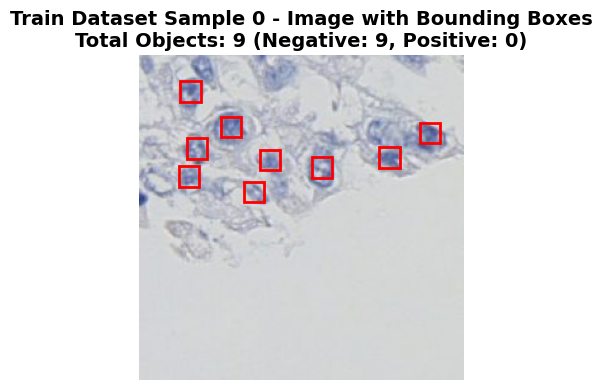

📊 Sample 0 상세 정보:
  이미지 크기: 256 x 256
  총 객체 수: 9
  PD-L1 negative: 9개
  PD-L1 positive: 0개

🔍 각 객체별 정보:
  객체 1: PD-L1 negative
    중심점: (0.156, 0.109)
    크기: 0.062 x 0.062
  객체 2: PD-L1 negative
    중심점: (0.281, 0.219)
    크기: 0.062 x 0.062
  객체 3: PD-L1 negative
    중심점: (0.895, 0.238)
    크기: 0.062 x 0.062
  객체 4: PD-L1 negative
    중심점: (0.176, 0.285)
    크기: 0.062 x 0.062
  객체 5: PD-L1 negative
    중심점: (0.770, 0.312)
    크기: 0.062 x 0.062
  객체 6: PD-L1 negative
    중심점: (0.402, 0.320)
    크기: 0.062 x 0.062
  객체 7: PD-L1 negative
    중심점: (0.562, 0.344)
    크기: 0.062 x 0.062
  객체 8: PD-L1 negative
    중심점: (0.152, 0.371)
    크기: 0.062 x 0.062
  객체 9: PD-L1 negative
    중심점: (0.352, 0.418)
    크기: 0.062 x 0.062


In [8]:
def visualize_sample_with_overlay(dataset, index=0):
    """
    데이터셋의 특정 샘플에 대해 바운딩 박스를 오버레이한 이미지를 시각화합니다.
    
    Args:
        dataset: 커스텀 데이터셋
        index: 시각화할 샘플의 인덱스
    """
    # 샘플 가져오기
    image_tensor, cls_tensor, box_tensor, _ = dataset[index]
    
    # 텐서를 numpy 배열로 변환
    # 이미지: (C, H, W) -> (H, W, C)
    image = image_tensor.numpy().transpose(1, 2, 0)
    cls = cls_tensor.numpy()
    boxes = box_tensor.numpy()
    
    # 이미지 크기
    height, width = image.shape[:2]
    
    # 클래스 이름 및 색상 설정
    class_names = {0: 'PD-L1 negative', 1: 'PD-L1 positive'}
    colors = ['red', 'blue']  # negative: red, positive: blue
    
    # 시각화
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(image.astype(np.uint8))
    
    # 각 바운딩 박스 그리기
    for i in range(len(boxes)):
        # YOLO 형식 (center_x, center_y, width, height)을 픽셀 좌표로 변환
        center_x, center_y, box_width, box_height = boxes[i]
        
        # 상대 좌표를 픽셀 좌표로 변환
        center_x_pixel = center_x * width
        center_y_pixel = center_y * height
        box_width_pixel = box_width * width
        box_height_pixel = box_height * height
        
        # 좌상단 좌표 계산
        x1 = center_x_pixel - box_width_pixel / 2
        y1 = center_y_pixel - box_height_pixel / 2
        
        # 클래스 정보
        class_id = int(cls[i])
        class_name = class_names.get(class_id, f'Class {class_id}')
        color = colors[class_id] if class_id < len(colors) else 'green'
        
        # 바운딩 박스 그리기
        rect = patches.Rectangle(
            (x1, y1), box_width_pixel, box_height_pixel,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        
    
    ax.set_title(f'Train Dataset Sample {index} - Image with Bounding Boxes\n'
                f'Total Objects: {len(boxes)} '
                f'(Negative: {sum(cls == 0)}, Positive: {sum(cls == 1)})', 
                fontsize=14, fontweight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 상세 정보 출력
    print(f"📊 Sample {index} 상세 정보:")
    print(f"  이미지 크기: {width} x {height}")
    print(f"  총 객체 수: {len(boxes)}")
    print(f"  PD-L1 negative: {sum(cls == 0)}개")
    print(f"  PD-L1 positive: {sum(cls == 1)}개")
    print("\n🔍 각 객체별 정보:")
    for i in range(len(boxes)):
        center_x, center_y, box_w, box_h = boxes[i]
        class_id = int(cls[i])
        class_name = class_names.get(class_id, f'Class {class_id}')
        print(f"  객체 {i+1}: {class_name}")
        print(f"    중심점: ({center_x:.3f}, {center_y:.3f})")
        print(f"    크기: {box_w:.3f} x {box_h:.3f}")

# train_dataset[0] 시각화 실행
print("🖼️ Train Dataset 첫 번째 샘플 시각화")
print("=" * 50)
visualize_sample_with_overlay(train_dataset, index=0)

In [4]:
def collate_fn1(batch):
    samples, cls, box, indices = zip(*batch)

    cls = torch.cat(cls, dim=0)
    box = torch.cat(box, dim=0)

    new_indices = list(indices)
    for i in range(len(indices)):
        new_indices[i] += i
    indices = torch.cat(new_indices, dim=0)

    targets = {'cls': cls,
                'box': box,
                'idx': indices}
    return torch.stack(samples, dim=0), targets


# 모델 및 파라미터 준비
model = nn.yolo_v11_n(len(params['names'])).to(device)
optimizer = torch.optim.SGD(util.set_params(model, params['weight_decay']),
                            2e-5, params['momentum'], nesterov=True)
criterion = util.ComputeLoss(model, params)

# 데이터셋 및 데이터로드 (안전한 함수 사용)
batch_size = 8
# 안전하게 데이터로더 생성하는 함수
def create_safe_loader(dataset, batch_size, is_train=True):
    """
    배치 크기에 맞게 데이터셋을 조정하여 안전하게 데이터로더를 생성하는 함수
    """
    dataset_size = len(dataset)
    
    # 배치 크기가 데이터셋 크기보다 큰 경우 배치 크기 조정
    if dataset_size < batch_size:
        print(f"경고: 데이터셋 크기({dataset_size})가 배치 크기({batch_size})보다 작습니다. 배치 크기를 {dataset_size}로 조정합니다.")
        actual_batch_size = max(1, dataset_size)
    else:
        actual_batch_size = batch_size
    
    # 데이터셋이 배치 크기로 나누어 떨어지는지 확인
    if dataset_size % actual_batch_size != 0:
        print(f"참고: 데이터셋 크기({dataset_size})가 배치 크기({actual_batch_size})로 나누어 떨어지지 않습니다.")
        print(f"마지막 배치는 {dataset_size % actual_batch_size}개의 샘플을 포함합니다.")
    
    # 데이터로더 생성
    loader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=actual_batch_size, 
        shuffle=is_train,
        num_workers=4,
        collate_fn=collate_fn1,
        drop_last=(not is_train)  # 훈련 시에는 마지막 배치 유지, 검증 시에는 마지막 배치 제외
    )
    
    return loader, actual_batch_size
# 안전하게 데이터로더 생성
loader, train_batch_size = create_safe_loader(train_dataset, batch_size, is_train=True)
val_loader, val_batch_size = create_safe_loader(val_dataset, 1, is_train=False)

print(f"최종 훈련 배치 크기: {train_batch_size}")
print(f"최종 검증 배치 크기: {val_batch_size}")



참고: 데이터셋 크기(7618)가 배치 크기(8)로 나누어 떨어지지 않습니다.
마지막 배치는 2개의 샘플을 포함합니다.
최종 훈련 배치 크기: 8
최종 검증 배치 크기: 1


In [5]:
from utils.valid import compute_validation_metrics, compute_validation_metrics_with_kappa, get_kappa_interpretation
from utils.valid import visualize_ground_truth_and_prediction_separately
from utils.valid import plot_training_progress


# main.py의 train 함수를 참조한 개선된 학습 루프
train_losses = []
val_maps = []
val_precisions = []
val_recalls = []
val_map50s = []
val_kappas = []  # Cohen's Kappa 추가
epochs = 10000

# 체크포인트 저장을 위한 디렉토리 생성
save_dir = '../../model/2class_yolov11/'
os.makedirs(save_dir, exist_ok=True)
#체크포인트 불러오기 
# checkpoint_path = os.path.join(save_dir, 'best_model.pt')
# if os.path.exists(checkpoint_path):
#     checkpoint = torch.load(checkpoint_path, map_location=device,weights_only=False)
#     model.load_state_dict(checkpoint['model_state_dict'])
    
# main.py 스타일의 설정들
best_map = 0
accumulate = max(round(64 / batch_size), 1)  # gradient accumulation steps
amp_scale = torch.amp.GradScaler()  # mixed precision scaler

print(f"Gradient accumulation steps: {accumulate}")

for epoch in range(epochs):
    # 훈련
    model.train()
    
    # main.py 스타일의 평균 손실 추적
    avg_box_loss = util.AverageMeter()
    avg_cls_loss = util.AverageMeter()
    avg_dfl_loss = util.AverageMeter()
    
    train_pbar = tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {epoch+1}/{epochs} Training')
    
    optimizer.zero_grad()
    
    for i, (images, targets) in train_pbar:
        step = i + len(loader) * epoch
        images = images.to(device).float() / 255
        
        # Forward pass with mixed precision
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss_box, loss_cls, loss_dfl = criterion(outputs, targets)
        
        # 평균 손실 업데이트
        avg_box_loss.update(loss_box.item(), images.size(0))
        avg_cls_loss.update(loss_cls.item(), images.size(0))
        avg_dfl_loss.update(loss_dfl.item(), images.size(0))
        
        # Loss scaling for gradient accumulation
        loss_box *= batch_size  # loss scaled by batch_size
        loss_cls *= batch_size  # loss scaled by batch_size  
        loss_dfl *= batch_size  # loss scaled by batch_size
        
        total_loss = loss_box + loss_cls + loss_dfl
        
        # Backward pass with gradient scaling
        amp_scale.scale(total_loss).backward()
        
        # Gradient accumulation 및 optimization
        if step % accumulate == 0:
            # Gradient clipping 및 optimization
            amp_scale.step(optimizer)
            amp_scale.update()
            optimizer.zero_grad()
        
        # GPU 메모리 동기화
        torch.cuda.synchronize()
        
        # 진행률 표시 업데이트 (main.py 스타일)
        memory = f'{torch.cuda.memory_reserved() / 1E9:.4g}G'
        s = f'Memory: {memory} | Box: {avg_box_loss.avg:.3f} | Cls: {avg_cls_loss.avg:.3f} | DFL: {avg_dfl_loss.avg:.3f}'
        train_pbar.set_description(f'Epoch {epoch+1}/{epochs} | {s}')
    
    # 에폭 평균 손실 계산
    avg_train_loss = avg_box_loss.avg + avg_cls_loss.avg + avg_dfl_loss.avg
    train_losses.append(avg_train_loss)
    
    # 검증 (Cohen's Kappa 포함)
    precision, recall, map50, mean_ap, kappa = compute_validation_metrics_with_kappa(
        model, val_loader, device, params
    )
    val_maps.append(mean_ap)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_map50s.append(map50)
    val_kappas.append(kappa)
    
    # F1-score 계산
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # 결과 출력 (Cohen's Kappa 포함)
    print(f"\nEpoch {epoch+1}/{epochs} Results:")
    print(f"  Train Loss - Box: {avg_box_loss.avg:.4f}, Cls: {avg_cls_loss.avg:.4f}, DFL: {avg_dfl_loss.avg:.4f}, Total: {avg_train_loss:.4f}")
    print(f"  Validation - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1_score:.4f}")
    print(f"  mAP@0.5: {map50:.4f}, mAP@0.5:0.95: {mean_ap:.4f}")
    print(f"  Cohen's Kappa: {kappa:.4f} ({get_kappa_interpretation(kappa)})")
    print("-" * 80)
    
    # 베스트 모델 저장 (mAP 기준)
    if mean_ap > best_map:
        best_map = mean_ap
        save_checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'amp_scale_state_dict': amp_scale.state_dict(),
            'train_loss': avg_train_loss,
            'box_loss': avg_box_loss.avg,
            'cls_loss': avg_cls_loss.avg,
            'dfl_loss': avg_dfl_loss.avg,
            'map': mean_ap,
            'map50': map50,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'kappa': kappa,
            'params': params
        }
        torch.save(save_checkpoint, os.path.join(save_dir, 'best_model.pt'))
        print(f"🎉 새로운 베스트 모델 저장! mAP: {mean_ap:.4f}, Kappa: {kappa:.4f}")
    
    # 최신 모델도 저장 (main.py 스타일)
    last_checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'amp_scale_state_dict': amp_scale.state_dict(),
        'train_loss': avg_train_loss,
        'box_loss': avg_box_loss.avg,
        'cls_loss': avg_cls_loss.avg,
        'dfl_loss': avg_dfl_loss.avg,
        'map': mean_ap,
        'map50': map50,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'kappa': kappa,
        'params': params
    }
    torch.save(last_checkpoint, os.path.join(save_dir, 'last_model.pt'))
    
    # 100 에폭마다 학습 진행 그래프 생성 및 저장
    if (epoch + 1) % 100 == 0:
        try:
            print(f"\n📊 Epoch {epoch+1} - 학습 진행 상황 그래프 생성 중...")
            plot_training_progress(train_losses, val_maps, val_precisions, val_recalls, val_map50s, epoch+1, save_dir)
        except Exception as e:
            print(f"그래프 생성 중 오류: {e}")
    
    # 개선된 검증 이미지 시각화 (매 10 에폭마다) - 실제 라벨과 예측 라벨을 별도 figure로 표시
    if (epoch+1) % 10 == 0:
        try:
            # 여러 샘플에 대해 시각화
            num_samples = 1 # 샘플 수를 1개
            for sample_idx in range(num_samples):
                print(f"\n📊 Epoch {epoch+1} - 검증 샘플 {sample_idx+1}/{num_samples}:")
                print("=" * 60)
                
                # 실제 라벨과 예측 라벨을 별도 figure로 표시
                sample_idx = random.randint(0, len(val_dataset)-1)
                visualize_ground_truth_and_prediction_separately(
                    model, val_dataset, idx=sample_idx, 
                    epoch=epoch+1, save_dir=save_dir
                )
                
        except Exception as e:
            print(f"시각화 중 오류: {e}")

print("🎯 학습 완료!")
print(f"최종 베스트 mAP: {best_map:.4f}")
print(f"모델 저장 위치: {save_dir}")
print(f"베스트 모델: {os.path.join(save_dir, 'best_model.pt')}")
print(f"최신 모델: {os.path.join(save_dir, 'last_model.pt')}")

# 최종 성능 요약
if val_kappas:
    final_kappa = val_kappas[-1]
    final_map = val_maps[-1]
    final_precision = val_precisions[-1]
    final_recall = val_recalls[-1]
    final_f1 = 2 * (final_precision * final_recall) / (final_precision + final_recall) if (final_precision + final_recall) > 0 else 0
    
    print(f"\n📊 최종 성능 요약:")
    print(f"  mAP@0.5:0.95: {final_map:.4f}")
    print(f"  Cohen's Kappa: {final_kappa:.4f} ({get_kappa_interpretation(final_kappa)})")
    print(f"  F1-score: {final_f1:.4f}")
    print(f"  Precision: {final_precision:.4f}")
    print(f"  Recall: {final_recall:.4f}")

Gradient accumulation steps: 8


Epoch 1/10000 Training:   0%|          | 0/953 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3611.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Epoch 1/10000 | Memory: 0.4006G | Box: 0.023 | Cls: 4.376 | DFL: 0.013:  81%|████████  | 769/953 [00:34<00:08, 22.31it/s] 


KeyboardInterrupt: 

In [ ]:
# Cohen's Kappa 관련 함수들을 valid.py에서 import
from utils.valid import compute_validation_metrics_with_kappa, get_kappa_interpretation, quick_kappa_test

# 현재 모델의 빠른 Cohen's Kappa 테스트
print("🔍 현재 모델의 Cohen's Kappa 빠른 측정...")
current_kappa = quick_kappa_test(model, val_loader, device)